In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from collections import deque
import random
import matplotlib.pyplot as plt
import pickle
from sklearn.decomposition import PCA

In [2]:
# Ignore warning messages
import warnings
warnings.filterwarnings('ignore')

In [3]:
file_path = '../bar_movement/data/'
currency_pair = 'Eur_Usd'

In [4]:
df = pd.read_csv(file_path + f'Oanda_{currency_pair}_D_2005-2023.csv')
df.Date = pd.to_datetime(df.Date, utc=True)
df.reset_index(drop=True, inplace=True)

In [5]:
def adx(high, low, close, lookback=14):
    plus_dm = high.diff()
    minus_dm = low.diff()
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0
    
    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift(1)))
    tr3 = pd.DataFrame(abs(low - close.shift(1)))
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
    atr = tr.rolling(lookback).mean()
    
    plus_di = 100 * (plus_dm.ewm(alpha = 1/lookback).mean() / atr)
    minus_di = abs(100 * (minus_dm.ewm(alpha = 1/lookback).mean() / atr))
    dx = (abs(plus_di - minus_di) / abs(plus_di + minus_di)) * 100
    adx = ((dx.shift(1) * (lookback - 1)) + dx) / lookback
    adx_smooth = adx.ewm(alpha = 1/lookback).mean()

    return adx_smooth

def stoch(high, low, close, lookback=14):
    high_lookback = high.rolling(lookback).max()
    low_lookback = low.rolling(lookback).min()
    slow_k = (close - low_lookback) * 100 / (high_lookback - low_lookback)
    slow_d = slow_k.rolling(3).mean()

    return slow_k, slow_d

def chop(df, lookback=14):
    atr1 = atr(df['Mid_High'], df['Mid_Low'], df['Mid_Close'], lookback=1)
    high, low = df['Mid_High'], df['Mid_Low']

    chop = np.log10(atr1.rolling(lookback).sum() / (high.rolling(lookback).max() - low.rolling(lookback).min())) / np.log10(lookback)

    return chop

def vo(volume, short_lookback=5, long_lookback=10):
    short_ema =  pd.Series.ewm(volume, span=short_lookback).mean()
    long_ema = pd.Series.ewm(volume, span=long_lookback).mean()

    volume_oscillator = (short_ema - long_ema) / long_ema

    return volume_oscillator

def williams_r(highs, lows, closes, length=21, ema_length=15):
    highest_highs = highs.rolling(window=length).max()
    lowest_lows = lows.rolling(window=length).min()

    willy = 100 * (closes - highest_highs) / (highest_highs - lowest_lows)
    willy_ema = pd.Series.ewm(willy, span=ema_length).mean()

    return willy, willy_ema

def squeeze(barsdata, length=20, length_kc=20, mult=1.5):
    # Bollinger bands
    m_avg = barsdata['Mid_Close'].rolling(window=length).mean()
    m_std = barsdata['Mid_Close'].rolling(window=length).std(ddof=0)
    upper_bb = m_avg + mult * m_std
    lower_bb = m_avg - mult * m_std

    # Keltner channel
    tr0 = abs(barsdata['Mid_High'] - barsdata['Mid_Low'])
    tr1 = abs(barsdata['Mid_High'] - barsdata['Mid_Close'].shift())
    tr2 = abs(barsdata['Mid_Low'] - barsdata['Mid_Close'].shift())
    tr = pd.concat([tr0, tr1, tr2], axis=1).max(axis=1)
    range_ma = tr.rolling(window=length_kc).mean()
    upper_kc = m_avg + range_ma * mult
    lower_kc = m_avg - range_ma * mult

    # Squeeze
    squeeze_on = (lower_bb > lower_kc) & (upper_bb < upper_kc)

    return squeeze_on

def atr(high, low, close, lookback=14):
    high_low = high - low
    high_close = np.abs(high - close.shift())
    low_close = np.abs(low - close.shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = np.max(ranges, axis=1)

    return true_range.rolling(lookback).mean()

def atr_bands(high, low, close, lookback=14, atr_multiplier=3):
    scaled_atr_vals = atr(high, low, close, lookback) * atr_multiplier
    lower_band = close - scaled_atr_vals
    upper_band = close + scaled_atr_vals

    return lower_band, upper_band

def rsi(closes, periods=14):
    close_delta = closes.diff()

    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        
    rsi = ma_up / ma_down
    rsi = 100 - (100 / (1 + rsi))

    return rsi

def qqe_mod(closes, rsi_period=6, smoothing=5, qqe_factor=3, threshold=3, mult=0.35, sma_length=50):
    Rsi = rsi(closes, rsi_period)
    RsiMa = Rsi.ewm(span=smoothing).mean()
    AtrRsi = np.abs(RsiMa.shift(1) - RsiMa)
    Wilders_Period = rsi_period * 2 - 1
    MaAtrRsi = AtrRsi.ewm(span=Wilders_Period).mean()
    dar = MaAtrRsi.ewm(span=Wilders_Period).mean() * qqe_factor

    longband = pd.Series(0.0, index=Rsi.index)
    shortband = pd.Series(0.0, index=Rsi.index)
    trend = pd.Series(0, index=Rsi.index)

    DeltaFastAtrRsi = dar
    RSIndex = RsiMa
    newshortband = RSIndex + DeltaFastAtrRsi
    newlongband = RSIndex - DeltaFastAtrRsi
    longband = pd.Series(np.where((RSIndex.shift(1) > longband.shift(1)) & (RSIndex > longband.shift(1)),
                        np.maximum(longband.shift(1), newlongband), newlongband))
    shortband = pd.Series(np.where((RSIndex.shift(1) < shortband.shift(1)) & (RSIndex < shortband.shift(1)),
                        np.minimum(shortband.shift(1), newshortband), newshortband))
    cross_1 = (longband.shift(1) < RSIndex) & (longband > RSIndex)
    cross_2 = (RSIndex > shortband.shift(1)) & (RSIndex.shift(1) < shortband)
    trend = np.where(cross_2, 1, np.where(cross_1, -1, trend.shift(1).fillna(1)))
    FastAtrRsiTL = pd.Series(np.where(trend == 1, longband, shortband))

    basis = (FastAtrRsiTL - 50).rolling(sma_length).mean()
    dev = mult * (FastAtrRsiTL - 50).rolling(sma_length).std()
    upper = basis + dev
    lower = basis - dev

    Greenbar1 = RsiMa - 50 > threshold
    Greenbar2 = RsiMa - 50 > upper

    Redbar1 = RsiMa - 50 < 0 - threshold
    Redbar2 = RsiMa - 50 < lower

    Greenbar = Greenbar1 & Greenbar2
    Redbar = Redbar1 & Redbar2

    return Greenbar, Redbar, RsiMa - 50

def heikin_ashi(open_values, high_values, low_values, close_values):
    ha_close = (open_values + high_values + low_values + close_values) / 4

    ha_open = pd.Series(0.0, index=open_values.index)
    ha_open.iloc[0] = open_values.iloc[0]

    for i in range(1, len(open_values)):
        ha_open.iloc[i] = (ha_open.iloc[i - 1] + ha_close.iloc[i - 1]) / 2

    ha_high = pd.concat([ha_open, ha_close, high_values], axis=1).max(axis=1)
    ha_low = pd.concat([ha_open, ha_close, low_values], axis=1).min(axis=1)

    return ha_open, ha_high, ha_low, ha_close

def trend_indicator(opens, highs, lows, closes, ema_period=50, smoothing_period=10):
    ha_open, _, _, ha_close = heikin_ashi(opens, highs, lows, closes)

    ha_o_ema = pd.Series.ewm(ha_open, span=ema_period).mean()
    ha_c_ema = pd.Series.ewm(ha_close, span=ema_period).mean()

    ha_o_ema_smooth = pd.Series.ewm(ha_o_ema, span=smoothing_period).mean()
    ha_c_ema_smooth = pd.Series.ewm(ha_c_ema, span=smoothing_period).mean()

    return ha_c_ema_smooth > ha_o_ema_smooth

def supertrend(barsdata, atr_len=10, mult=3):
    curr_atr = atr(barsdata['Mid_High'], barsdata['Mid_Low'], barsdata['Mid_Close'], lookback=atr_len)
    highs, lows = barsdata['Mid_High'], barsdata['Mid_Low']
    hl2 = (highs + lows) / 2
    final_upperband = hl2 + mult * curr_atr
    final_lowerband = hl2 - mult * curr_atr

    # initialize Supertrend column to True
    supertrend = [True] * len(df)

    close = barsdata['Mid_Close']
    
    for i in range(1, len(df.index)):
        curr, prev = i, i - 1
        
        # if current close price crosses above upperband
        if close[curr] > final_upperband[prev]:
            supertrend[curr] = True

        # if current close price crosses below lowerband
        elif close[curr] < final_lowerband[prev]:
            supertrend[curr] = False

        # else, the trend continues
        else:
            supertrend[curr] = supertrend[prev]
            
            # adjustment to the final bands
            if supertrend[curr] == True and final_lowerband[curr] < final_lowerband[prev]:
                final_lowerband[curr] = final_lowerband[prev]

            if supertrend[curr] == False and final_upperband[curr] > final_upperband[prev]:
                final_upperband[curr] = final_upperband[prev]

    return supertrend, final_upperband, final_lowerband

def fractal(lows, highs, window=20):
    assert len(lows) == len(highs)

    fractal_period = 2 * window + 1

    is_support = lows.rolling(fractal_period, center=True).apply(lambda x: x[window] == min(x), raw=True)
    is_resistance = highs.rolling(fractal_period, center=True).apply(lambda x: x[window] == max(x), raw=True)
    
    is_support_indices = pd.Series(is_support.index[is_support == 1.0])
    is_resistance_indices = pd.Series(is_resistance.index[is_resistance == 1.0])

    support_fractal_vals = lows[is_support_indices].reindex(lows.index).ffill()
    resistance_fractal_vals = highs[is_resistance_indices].reindex(highs.index).ffill()

    return support_fractal_vals, resistance_fractal_vals

In [6]:
pips_multiplier = 100 if 'Jpy' in currency_pair else 10000

df['rsi'] = rsi(df['Mid_Close'])
df['rsi_ema'] = pd.Series.ewm(df['rsi'], span=50).mean()
df['adx'] = adx(df['Mid_High'], df['Mid_Low'], df['Mid_Close'])
df['chop'] = chop(df)
df['vo'] = vo(df['Volume'])
df['qqe_up'], df['qqe_down'], df['qqe_val'] = qqe_mod(df['Mid_Close'])
df['rsi_up'] = df['rsi'] > df['rsi_ema']
df['adx_large'] = df['adx'] > 30
df['chop_small'] = df['chop'] < 0.5
df['vo_positive'] = df['vo'] > 0
# df['ask_pips_up'], df['ask_pips_down'] = abs(df['Ask_High'] - df['Ask_Open']), abs(df['Ask_Open'] - df['Ask_Low'])
# df['ask_pips_up_ema'], df['ask_pips_down_ema'] = pd.Series.ewm(df['ask_pips_up'], span=50).mean(), pd.Series.ewm(df['ask_pips_down'], span=50).mean()
# df['bid_pips_up'], df['bid_pips_down'] = abs(df['Bid_High'] - df['Bid_Open']), abs(df['Bid_Open'] - df['Bid_Low'])
# df['bid_pips_up_ema'], df['bid_pips_down_ema'] = pd.Series.ewm(df['bid_pips_up'], span=50).mean(), pd.Series.ewm(df['bid_pips_down'], span=50).mean()
df['mid_pips_up'], df['mid_pips_down'] = abs(df['Mid_High'] - df['Mid_Open']), abs(df['Mid_Open'] - df['Mid_Low'])
df['mid_pips_up_ema'], df['mid_pips_down_ema'] = pd.Series.ewm(df['mid_pips_up'], span=50).mean(), pd.Series.ewm(df['mid_pips_down'], span=50).mean()

# rsi_vals = rsi(df['Mid_Close'])
# df['rsi_ema'] = pd.Series.ewm(rsi_vals, span=50).mean()

# adx_vals = adx(df['Mid_High'], df['Mid_Low'], df['Mid_Close'])
# df['adx_ema'] = pd.Series.ewm(adx_vals, span=50).mean()

# chop_vals = chop(df)
# df['chop_ema'] = pd.Series.ewm(chop_vals, span=50).mean()

# vo_vals = vo(df['Volume'])
# df['vo_ema'] = pd.Series.ewm(vo_vals, span=50).mean()

# qqe_up_vals, qqe_down_vals, qqe_val_vals = qqe_mod(df['Mid_Close'])
# df['qqe_up_ema'] = pd.Series.ewm(qqe_up_vals, span=50).mean()
# df['qqe_down_ema'] = pd.Series.ewm(qqe_down_vals, span=50).mean()
# df['qqe_val_ema'] = pd.Series.ewm(qqe_val_vals, span=50).mean()

# rsi_up_vals = rsi_vals > df['rsi_ema']
# df['rsi_up_ema'] = pd.Series.ewm(rsi_up_vals, span=50).mean()

# adx_large_vals = adx_vals > 30
# df['adx_large_ema'] = pd.Series.ewm(adx_large_vals, span=50).mean()

# chop_small_vals = chop_vals < 0.5
# df['chop_small_ema'] = pd.Series.ewm(chop_small_vals, span=50).mean()

# vo_positive_vals = vo_vals > 0
# df['vo_positive_ema'] = pd.Series.ewm(vo_positive_vals, span=50).mean()

# ask_pips_up, ask_pips_down = abs(df['Ask_High'] - df['Ask_Open']), abs(df['Ask_Open'] - df['Ask_Low'])
# df['ask_pips_up_ema'], df['ask_pips_down_ema'] = pd.Series.ewm(ask_pips_up, span=50).mean(), pd.Series.ewm(ask_pips_down, span=50).mean()

# bid_pips_up, bid_pips_down = abs(df['Bid_High'] - df['Bid_Open']), abs(df['Bid_Open'] - df['Bid_Low'])
# df['bid_pips_up_ema'], df['bid_pips_down_ema'] = pd.Series.ewm(bid_pips_up, span=50).mean(), pd.Series.ewm(bid_pips_down, span=50).mean()

df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

prices = df[['Date', 'Bid_Open', 'Bid_High', 'Bid_Low', 'Bid_Close', 'Ask_Open', 'Ask_High', 'Ask_Low', 'Ask_Close', 'Mid_Open', 'Mid_High', 'Mid_Low', 'Mid_Close', 'Volume']]
df.drop(['Bid_Open', 'Bid_High', 'Bid_Low', 'Bid_Close', 'Ask_Open', 'Ask_High', 'Ask_Low', 'Ask_Close', 'Mid_Open', 'Mid_High', 'Mid_Low', 'Mid_Close', 'Volume'], axis=1, inplace=True)

assert len(prices) == len(df)

In [7]:
cutoff_date = '2022-06-15 05:00:00'

df_train = df.loc[df['Date'] <= cutoff_date]
df_train.reset_index(drop=True, inplace=True)
prices_train = prices.loc[prices['Date'] <= cutoff_date]
prices_train.reset_index(drop=True, inplace=True)

df_test = df.loc[df['Date'] > cutoff_date]
df_test.reset_index(drop=True, inplace=True)
prices_test = prices.loc[prices['Date'] > cutoff_date]
prices_test.reset_index(drop=True, inplace=True)

df_train.drop(['Date'], axis=1, inplace=True)

In [8]:
scaler = StandardScaler()
df_train = scaler.fit_transform(df_train)

In [9]:
explained_variance = 0.99

pca = PCA(n_components=explained_variance)
df_train = pca.fit_transform(df_train)

In [10]:
training_data = []

In [11]:
def transform(x):
    return np.log(x + 1)

def untransform(x):
    return np.exp(x) - 1

In [12]:
for i in range(1, len(df_train)):
    # mid_open, mid_high, mid_low, ask_open, ask_high, ask_low, bid_open, bid_high, bid_low = prices_train.loc[prices_train.index[i], ['Mid_Open', 'Mid_High', 'Mid_Low', 'Ask_Open', 'Ask_High', 'Ask_Low', 'Bid_Open', 'Bid_High', 'Bid_Low']]
    mid_open, mid_high, mid_low = prices_train.loc[prices_train.index[i], ['Mid_Open', 'Mid_High', 'Mid_Low']]

    # ask_pips_up, ask_pips_down, bid_pips_up, bid_pips_down = abs(ask_high - ask_open) * pips_multiplier, abs(ask_open - ask_low) * pips_multiplier, abs(bid_high - bid_open) * pips_multiplier, abs(bid_open - bid_low) * pips_multiplier
    mid_pips_up, mid_pips_down = transform(abs(mid_high - mid_open) * pips_multiplier), transform(abs(mid_open - mid_low) * pips_multiplier)
    # training_data.append([np.array(df_train[i - 1, :]), np.array([ask_pips_up, ask_pips_down, bid_pips_up, bid_pips_down])])
    training_data.append([np.array(df_train[i - 1, :]), np.array([mid_pips_up, mid_pips_down])])

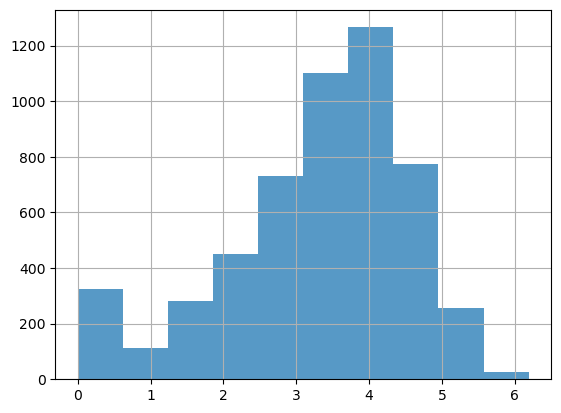

In [13]:
plt.grid()
plt.hist(transform(df['mid_pips_up'] * pips_multiplier), alpha=0.75)
plt.show()

In [14]:
np.random.shuffle(training_data)

train_set_ratio = 0.7
cutoff_index = int(len(training_data) * train_set_ratio)
train_set, validation_set = training_data[:cutoff_index], training_data[cutoff_index:]

In [15]:
x_train = []
y_train = []

for seq, target in train_set:
  x_train.append(seq)
  y_train.append(target)

x_validation = []
y_validation = []

for seq, target in validation_set:
  x_validation.append(seq)
  y_validation.append(target)

x_train = np.array(x_train)
y_train = np.array(y_train)
x_validation = np.array(x_validation)
y_validation = np.array(y_validation)

print(x_train.shape, y_train.shape, x_validation.shape, y_validation.shape)

(3539, 14) (3539, 2) (1518, 14) (1518, 2)


In [16]:
all_combos = []

for n_estimators in [5, 10, 15, 20, 25, 50]:
    for min_samples_leaf in [5, 10, 15, 20, 25, 50]:
        for max_depth in [3, 4, 5, 6, 7, 8, 9, 10]:
            for min_samples_split in [2, 3, 4, 5, 10, 15]:
                all_combos.append((n_estimators, min_samples_leaf, max_depth, min_samples_split))

percentage_to_try = 0.25
n_runs = int(percentage_to_try * len(all_combos))
combos_to_try = random.sample(all_combos, n_runs)
print(f'Num runs: {n_runs}')

best_validation_mse = np.inf
model = None

for n_estimators, min_samples_leaf, max_depth, min_samples_split in combos_to_try:
    curr_model = RandomForestRegressor(n_estimators=n_estimators, min_samples_leaf=min_samples_leaf, max_depth=max_depth, min_samples_split=min_samples_split)
    curr_model.fit(x_train, y_train)

    y_validation_pred = curr_model.predict(x_validation)
    validation_mse = np.square(y_validation_pred - y_validation).mean()

    if validation_mse < best_validation_mse:
        best_validation_mse, model = validation_mse, curr_model

    n_runs -= 1
    print(f'Remaining runs: {n_runs}')
    

Num runs: 432
Remaining runs: 431
Remaining runs: 430
Remaining runs: 429
Remaining runs: 428
Remaining runs: 427
Remaining runs: 426
Remaining runs: 425
Remaining runs: 424
Remaining runs: 423
Remaining runs: 422
Remaining runs: 421
Remaining runs: 420
Remaining runs: 419
Remaining runs: 418
Remaining runs: 417
Remaining runs: 416
Remaining runs: 415
Remaining runs: 414
Remaining runs: 413
Remaining runs: 412
Remaining runs: 411
Remaining runs: 410
Remaining runs: 409
Remaining runs: 408
Remaining runs: 407
Remaining runs: 406
Remaining runs: 405
Remaining runs: 404
Remaining runs: 403
Remaining runs: 402
Remaining runs: 401
Remaining runs: 400
Remaining runs: 399
Remaining runs: 398
Remaining runs: 397
Remaining runs: 396
Remaining runs: 395
Remaining runs: 394
Remaining runs: 393
Remaining runs: 392
Remaining runs: 391
Remaining runs: 390
Remaining runs: 389
Remaining runs: 388
Remaining runs: 387
Remaining runs: 386
Remaining runs: 385
Remaining runs: 384
Remaining runs: 383
Remain

In [17]:
best_validation_mse

1.6368437460697918

In [18]:
avg_dist = (prices['Mid_High'] - prices['Mid_Low']).mean() * pips_multiplier
print(avg_dist, avg_dist / 2, (avg_dist / 2) ** 2)

95.2427899981199 47.62139499905995 2267.797261656492


In [24]:
# param_grid = {'n_estimators': [5, 10, 15, 20, 25, 50],
#               'min_samples_leaf': [5, 10, 15, 20, 25, 50],
#               'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
#               'min_samples_split': [2, 3, 4, 5, 10, 15]}

# random_search = RandomizedSearchCV(RandomForestRegressor(), param_grid, cv=2, n_iter=100)
# random_search.fit(x_train, y_train)

# model = random_search.best_estimator_

In [32]:
# y_validation_pred = model.predict(x_validation)
# validation_mse = np.square(y_validation_pred - y_validation).mean()

# validation_mse

In [19]:
with open(f'./rf_d_{currency_pair.lower()}.pickle', 'wb') as f:
    pickle.dump(model, f)

with open(f'./rf_d_scaler_{currency_pair.lower()}.pickle', 'wb') as f:
    pickle.dump(scaler, f)

# with open(f'./rf_h4_pca_{currency_pair.lower()}.pickle', 'wb') as f:
#     pickle.dump(pca, f)

In [22]:
value_per_pip = 1.0
amounts_per_day = [-0.008, -0.01, -0.012] if 'Jpy' in currency_pair else [-0.00008, -0.0001, -0.00012]
rounding = 3 if 'Jpy' in currency_pair else 5
df = pd.read_csv(file_path + f'Oanda_{currency_pair}_M5_2022-2023.csv')
df.Date = pd.to_datetime(df.Date, utc=True)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
validation_avg_error = 2215.4681145353898 ** 0.5

In [23]:
def get_n_units(trade_type, stop_loss, ask_open, bid_open, mid_open, currency_pair):
    _, second = currency_pair.split('_')
  
    pips_to_risk = ask_open - stop_loss if trade_type == 'buy' else stop_loss - bid_open
    pips_to_risk_calc = pips_to_risk * 10000 if second != 'Jpy' else pips_to_risk * 100

    if second == 'Usd':
        per_pip = 0.0001

    else:
        per_pip = 0.0001 / mid_open if second != 'Jpy' else 0.01 / mid_open

    n_units = int(50 / (pips_to_risk_calc * per_pip))

    return n_units

def calculate_day_fees(start_date, end_date, n_units):
    curr_fee = np.random.choice(amounts_per_day, p=[0.25, 0.50, 0.25]) * n_units
    num_days = np.busday_count(start_date.date(), end_date.date())

    return num_days * curr_fee

def run_simulation(pips_to_risk, adapt_errors, error_array_len, error_multiplier, invert):
    reward, day_fees, n_wins, n_losses, win_streak, loss_streak, curr_win_streak, curr_loss_streak, n_buys, n_sells = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
    pips_risked, win_amounts, loss_amounts = [], [], []
    prev_long_date, trade = None, None
    sl_pips = pips_to_risk / pips_multiplier

    # ask_pips_up_errors, ask_pips_down_errors, bid_pips_up_errors, bid_pips_down_errors = deque(maxlen=error_array_len), deque(maxlen=error_array_len), deque(maxlen=error_array_len), deque(maxlen=error_array_len)
    mid_pips_up_errors, mid_pips_down_errors = deque(maxlen=error_array_len), deque(maxlen=error_array_len)

    for _ in range(error_array_len):
        # ask_pips_up_errors.append(validation_avg_error)
        # ask_pips_down_errors.append(validation_avg_error)
        # bid_pips_up_errors.append(validation_avg_error)
        # bid_pips_down_errors.append(validation_avg_error)
        mid_pips_up_errors.append(validation_avg_error)
        mid_pips_down_errors.append(validation_avg_error)

    for i in range(len(df)):
        curr_date, curr_ao, curr_bo, curr_mid_open, curr_ask_low, curr_bid_high, curr_bid_low, curr_ask_high, curr_bid_close, curr_ask_close = df.loc[df.index[i], ['Date', 'Ask_Open', 'Bid_Open', 'Mid_Open', 'Ask_Low', 'Bid_High', 'Bid_Low', 'Ask_High', 'Bid_Close', 'Ask_Close']]
        spread = abs(curr_ao - curr_bo)

        curr_long_df = df_test.loc[df_test.Date <= curr_date]
        gte = df_test.loc[df_test.Date >= curr_date]

        if len(gte) == 0:
            break

        curr_long_df_len = len(curr_long_df)

        if curr_long_df_len < 2:
            continue

        curr_long_date = curr_long_df.loc[curr_long_df.index[-2], 'Date']

        if trade is None and curr_long_date != prev_long_date:
            prev_long_date = curr_long_date

            # seq = scaler.transform(np.array(curr_long_df.iloc[-2, 1:]).reshape(1, -1))
            seq = pca.transform(scaler.transform(np.array(curr_long_df.iloc[-2, 1:]).reshape(1, -1)))

            # ask_pips_up_pred, ask_pips_down_pred, bid_pips_up_pred, bid_pips_down_pred = model.predict(seq.reshape(1, -1))[0]
            mid_pips_up_pred, mid_pips_down_pred = model.predict(seq.reshape(1, -1))[0]
            mid_pips_up_pred, mid_pips_down_pred = untransform(mid_pips_up_pred), untransform(mid_pips_down_pred)

            # ask_pips_up_error_avg = np.array(ask_pips_up_errors).mean() if adapt_errors else validation_avg_error
            # ask_pips_down_error_avg = np.array(ask_pips_down_errors).mean() if adapt_errors else validation_avg_error
            # bid_pips_up_error_avg = np.array(bid_pips_up_errors).mean() if adapt_errors else validation_avg_error
            # bid_pips_down_error_avg = np.array(bid_pips_down_errors).mean() if adapt_errors else validation_avg_error
            mid_pips_up_error_avg = np.array(mid_pips_up_errors).mean() if adapt_errors else validation_avg_error
            mid_pips_down_error_avg = np.array(mid_pips_down_errors).mean() if adapt_errors else validation_avg_error

            if adapt_errors:
                curr_prices_long = prices_test.loc[prices_test.Date <= curr_date]
                # ask_open, ask_high, ask_low, bid_open, bid_high, bid_low = curr_prices_long.loc[curr_prices_long.index[-1], ['Ask_Open', 'Ask_High', 'Ask_Low', 'Bid_Open', 'Bid_High', 'Bid_Low']]
                # ask_pips_up_true, ask_pips_down_true, bid_pips_up_true, bid_pips_down_true = abs(ask_high - ask_open) * pips_multiplier, abs(ask_open - ask_low) * pips_multiplier, abs(bid_high - bid_open) * pips_multiplier, abs(bid_open - bid_low) * pips_multiplier

                # ask_pips_up_errors.append(abs(ask_pips_up_true - ask_pips_up_pred))
                # ask_pips_down_errors.append(abs(ask_pips_down_true - ask_pips_down_pred))
                # bid_pips_up_errors.append(abs(bid_pips_up_true - bid_pips_up_pred))
                # bid_pips_down_errors.append(abs(bid_pips_down_true - bid_pips_down_pred))
                mid_open, mid_high, mid_low = curr_prices_long.loc[curr_prices_long.index[-1], ['Mid_Open', 'Mid_High', 'Mid_Low']]
                # ask_pips_up_true, ask_pips_down_true, bid_pips_up_true, bid_pips_down_true = abs(ask_high - ask_open) * pips_multiplier, abs(ask_open - ask_low) * pips_multiplier, abs(bid_high - bid_open) * pips_multiplier, abs(bid_open - bid_low) * pips_multiplier
                mid_pips_up_true, mid_pips_down_true = abs(mid_high - mid_open) * pips_multiplier, abs(mid_open - mid_low) * pips_multiplier

                # ask_pips_up_errors.append(abs(ask_pips_up_true - ask_pips_up_pred))
                # ask_pips_down_errors.append(abs(ask_pips_down_true - ask_pips_down_pred))
                # bid_pips_up_errors.append(abs(bid_pips_up_true - bid_pips_up_pred))
                # bid_pips_down_errors.append(abs(bid_pips_down_true - bid_pips_down_pred))
                mid_pips_up_errors.append(abs(mid_pips_up_true - mid_pips_up_pred))
                mid_pips_down_errors.append(abs(mid_pips_down_true - mid_pips_down_pred))

            
            # ask_pips_up_pred = ask_pips_up_pred + (ask_pips_up_error_avg * error_multiplier)
            # ask_pips_down_pred = ask_pips_down_pred + (ask_pips_down_error_avg * error_multiplier)
            # bid_pips_up_pred = bid_pips_up_pred + (bid_pips_up_error_avg * error_multiplier)
            # bid_pips_down_pred = bid_pips_down_pred + (bid_pips_down_error_avg * error_multiplier)
            mid_pips_up_pred = mid_pips_up_pred + (mid_pips_up_error_avg * error_multiplier)
            mid_pips_down_pred = mid_pips_down_pred + (mid_pips_down_error_avg * error_multiplier)

            # buy_signal = max([ask_pips_up_pred, ask_pips_down_pred, bid_pips_up_pred, bid_pips_down_pred]) == bid_pips_up_pred and bid_pips_up_pred >= pips_to_risk and bid_pips_down_pred < pips_to_risk
            # sell_signal = max([ask_pips_up_pred, ask_pips_down_pred, bid_pips_up_pred, bid_pips_down_pred]) == ask_pips_down_pred and ask_pips_down_pred >= pips_to_risk and ask_pips_up_pred < pips_to_risk
            buy_signal = max([mid_pips_up_pred, mid_pips_down_pred]) == mid_pips_up_pred and mid_pips_up_pred >= pips_to_risk and mid_pips_down_pred < pips_to_risk
            sell_signal = max([mid_pips_up_pred, mid_pips_down_pred]) == mid_pips_down_pred and mid_pips_down_pred >= pips_to_risk and mid_pips_up_pred < pips_to_risk

            if invert:
                buy_signal, sell_signal = sell_signal, buy_signal

            if buy_signal:
                open_price = float(curr_ao)
                stop_loss = round(open_price - sl_pips, rounding)

                if stop_loss < open_price:
                    curr_pips_to_risk = open_price - stop_loss

                    if spread <= curr_pips_to_risk * 0.1:
                        n_units = get_n_units('buy', stop_loss, curr_ao, curr_bo, curr_mid_open, currency_pair)

                        trade = {'start_index': i, 'open_price': open_price, 'trade_type': 'buy', 'stop_loss': stop_loss,
                                'pips_risked': round(curr_pips_to_risk, 5), 'n_units': n_units, 
                                'original_units': n_units, 'start_date': curr_date, 'end_date': None, 'prev_profit_ratio': None}
                        
                        pips_risked.append(curr_pips_to_risk)
                        n_buys += 1

            elif sell_signal:
                open_price = float(curr_bo)
                stop_loss = round(open_price + sl_pips, rounding)

                if stop_loss > open_price:
                    curr_pips_to_risk = stop_loss - open_price

                    if spread <= curr_pips_to_risk * 0.1:
                        n_units = get_n_units('sell', stop_loss, curr_ao, curr_bo, curr_mid_open, currency_pair)

                        trade = {'start_index': i, 'open_price': open_price, 'trade_type': 'sell', 'stop_loss': stop_loss,
                                'pips_risked': round(curr_pips_to_risk, 5), 'n_units': n_units, 
                                'original_units': n_units, 'start_date': curr_date, 'end_date': None, 'prev_profit_ratio': None}
                        
                        pips_risked.append(curr_pips_to_risk)
                        n_sells += 1

        if trade is not None and trade['trade_type'] == 'buy' and curr_bid_low <= trade['stop_loss']:
            trade_amount = (trade['stop_loss'] - trade['open_price']) * trade['n_units'] * value_per_pip
            reward += trade_amount
            day_fees += calculate_day_fees(trade['start_date'], curr_date, trade['n_units'])

            if trade_amount > 0:
                win_amounts.append(trade_amount)

            else:
                loss_amounts.append(trade_amount)

            n_wins += 1 if trade_amount > 0 else 0
            n_losses += 1 if trade_amount < 0 else 0
            curr_win_streak = 0 if trade_amount < 0 else curr_win_streak + 1
            curr_loss_streak = 0 if trade_amount > 0 else curr_loss_streak + 1

            if curr_win_streak > win_streak:
                win_streak = curr_win_streak

            if curr_loss_streak > loss_streak:
                loss_streak = curr_loss_streak

            trade = None

        if trade is not None and trade['trade_type'] == 'buy' and curr_bid_close > trade['open_price']:
            curr_profit_ratio = (curr_bid_close - trade['open_price']) / trade['pips_risked']

            # Initial move
            if curr_profit_ratio >= 1.0 and trade['prev_profit_ratio'] is None:
                trade['stop_loss'] = trade['open_price']
                trade['prev_profit_ratio'] = 0.0

            # if curr_profit_ratio >= 1.5 and trade['prev_profit_ratio'] == 0.0:
            #     trade['stop_loss'] = trade['open_price'] + (trade['pips_risked'] * 0.5)
            #     trade['prev_profit_ratio'] = 0.5

            # Subsequent moves
            if curr_profit_ratio >= 2.0:
                # while curr_profit_ratio >= trade['prev_profit_ratio'] + 1.5:
                while curr_profit_ratio >= trade['prev_profit_ratio'] + 2.0:
                    # trade['prev_profit_ratio'] += 0.5
                    trade['prev_profit_ratio'] += 1.0
                    trade['stop_loss'] = trade['open_price'] + (trade['pips_risked'] * trade['prev_profit_ratio'])

        if trade is not None and trade['trade_type'] == 'sell' and curr_ask_high >= trade['stop_loss']:
            trade_amount = (trade['open_price'] - trade['stop_loss']) * trade['n_units'] * value_per_pip
            reward += trade_amount
            day_fees += calculate_day_fees(trade['start_date'], curr_date, trade['n_units'])

            if trade_amount > 0:
                win_amounts.append(trade_amount)

            else:
                loss_amounts.append(trade_amount)

            n_wins += 1 if trade_amount > 0 else 0
            n_losses += 1 if trade_amount < 0 else 0
            curr_win_streak = 0 if trade_amount < 0 else curr_win_streak + 1
            curr_loss_streak = 0 if trade_amount > 0 else curr_loss_streak + 1

            if curr_win_streak > win_streak:
                win_streak = curr_win_streak

            if curr_loss_streak > loss_streak:
                loss_streak = curr_loss_streak

            trade = None

        if trade is not None and trade['trade_type'] == 'sell' and curr_ask_close < trade['open_price']:
            curr_profit_ratio = (trade['open_price'] - curr_ask_close) / trade['pips_risked']

            # Initial move
            if curr_profit_ratio >= 1.0 and trade['prev_profit_ratio'] is None:
                trade['stop_loss'] = trade['open_price']
                trade['prev_profit_ratio'] = 0.0

            # if curr_profit_ratio >= 1.5 and trade['prev_profit_ratio'] == 0.0:
            #     trade['stop_loss'] = trade['open_price'] - (trade['pips_risked'] * 0.5)
            #     trade['prev_profit_ratio'] = 0.5

            # Subsequent moves
            if curr_profit_ratio >= 2.0:
                # while curr_profit_ratio >= trade['prev_profit_ratio'] + 1.5:
                while curr_profit_ratio >= trade['prev_profit_ratio'] + 2.0:
                    # trade['prev_profit_ratio'] += 0.5
                    trade['prev_profit_ratio'] += 1.0
                    trade['stop_loss'] = trade['open_price'] - (trade['pips_risked'] * trade['prev_profit_ratio'])

    return reward, day_fees, n_buys, n_sells, n_wins, n_losses, win_streak, loss_streak, pips_risked, win_amounts, loss_amounts

In [24]:
pips_to_risk_vals = [30, 40, 50, 60, 70, 80, 90, 100, 150] 
error_multipliers = [0.0, 0.5, 1.0, 1.5, 2.0]
adapt_errors_vals = [True, False]
error_array_lens = [5, 10, 20] 
invert_vals = [True, False]

all_combos = []

for pips_to_risk in pips_to_risk_vals:
    for error_multiplier in error_multipliers:
        for invert in invert_vals:
            for adapt_errors in adapt_errors_vals:
                for err_array_len in error_array_lens:
                    error_array_len = err_array_len if adapt_errors else 1
                    all_combos.append((pips_to_risk, adapt_errors, error_array_len, error_multiplier, invert))

                    if not adapt_errors:
                        break

best_pips_to_risk, best_adapt_errors, best_error_array_len, best_error_multiplier, best_invert_val = None, None, None, None, None
top_n_results, best_rewards, best_reward, runs_finished = 10, [], -np.inf, 0

percentage_to_try = 1.0
n_runs = int(percentage_to_try * len(all_combos))
combos_to_try = random.sample(all_combos, n_runs)
print('Num runs: '+ str(len(combos_to_try)) + '\n')

for pips_to_risk, adapt_errors, error_array_len, error_multiplier, invert in combos_to_try:
    reward, day_fees, n_buys, n_sells, n_wins, n_losses, win_streak, loss_streak, pips_risked, win_amounts, loss_amounts = run_simulation(pips_to_risk, adapt_errors, error_array_len, error_multiplier, invert)
    runs_finished += 1

    print(reward, day_fees, reward + day_fees)
    print('Num buys: ' + str(n_buys))
    print('Num sells: ' + str(n_sells))
    print('Num trades: ' + str(n_buys + n_sells))
    print('Num wins: ' + str(n_wins))
    print('Num losses: ' + str(n_losses))
    print('Win streak: ' + str(win_streak))
    print('Loss streak: ' + str(loss_streak))
    if len(pips_risked) > 0:
        print('Avg pips risked: ' + str(np.array(pips_risked).mean()))
    if len(win_amounts) > 0:
        print('Avg win amount: ' + str(np.array(win_amounts).mean()))
        print('Min win amount: ' +  str(min(win_amounts)))
        print('Max win amount: ' + str(max(win_amounts)))
    if len(loss_amounts) > 0:
        print('Avg loss amount: ' + str(np.array(loss_amounts).mean()))
        print('Min loss amount: ' +  str(min(loss_amounts)))
        print('Max loss amount: ' + str(max(loss_amounts)))

    print('Remaining runs: ' + str(n_runs - runs_finished))

    total_profit = reward + day_fees

    min_item = min(best_rewards, key=lambda entry: entry['reward']) if len(best_rewards) >= top_n_results else None

    if min_item is None or total_profit > min_item['reward']:
        if min_item is not None:
            best_rewards.remove(min_item)
            
        best_rewards.append({'reward': int(total_profit), 'pips_to_risk': pips_to_risk, 'adapt_errors': adapt_errors, 'error_array_len': error_array_len, 'error_multiplier': error_multiplier, 'invert': invert})

    if total_profit > best_reward:
        best_reward = total_profit
        best_pips_to_risk, best_adapt_errors, best_error_array_len, best_error_multiplier, best_invert_val = pips_to_risk, adapt_errors, error_array_len, error_multiplier, invert
 
    print('Best reward so far: ' + str(best_reward))
    print()


Num runs: 360

0 0 0
Num buys: 0
Num sells: 0
Num trades: 0
Num wins: 0
Num losses: 0
Win streak: 0
Loss streak: 0
Remaining runs: 359
Best reward so far: 0

0 0 0
Num buys: 0
Num sells: 0
Num trades: 0
Num wins: 0
Num losses: 0
Win streak: 0
Loss streak: 0
Remaining runs: 358
Best reward so far: 0

-0.00499999999779277 -25.999000000000002 -26.003999999997795
Num buys: 10
Num sells: 1
Num trades: 11
Num wins: 4
Num losses: 6
Win streak: 2
Loss streak: 4
Avg pips risked: 0.004999999999999954
Avg win amount: 74.99749999999952
Min win amount: 49.999999999998934
Max win amount: 100.00000000000009
Avg loss amount: -42.85642857142797
Min loss amount: -49.999999999998934
Max loss amount: 0.0
Remaining runs: 357
Best reward so far: 0

0 0 0
Num buys: 0
Num sells: 0
Num trades: 0
Num wins: 0
Num losses: 0
Win streak: 0
Loss streak: 0
Remaining runs: 356
Best reward so far: 0

-99.99200000000147 -23.99808 -123.99008000000147
Num buys: 3
Num sells: 9
Num trades: 12
Num wins: 3
Num losses: 6
Win s

In [23]:
print('------------ FINAL RESULTS ------------')
print('Best reward: ' + str(best_reward))
print('Best pips to risk: ' + str(best_pips_to_risk))
print('Best adapt errors val: ' + str(best_adapt_errors))
print('Best error array length: ' + str(best_error_array_len))
print('Best best error multiplier: ' + str(best_error_multiplier))
print('Best best invert val: ' + str(best_invert_val))
print('-----------------------')
print('Top results:')

for entry in best_rewards:
    print(entry)

------------ FINAL RESULTS ------------
Best reward: 1224.9509999999736
Best sl multiplier: 1.0
Best pips to risk: 30
Best adapt errors val: True
Best error array length: 5
Best best standard deviation: 0.0
Best best use abs adjustment: False
Best best invert val: True
-----------------------
Top results:
{'reward': 1184, 'sl_multiplier': 1.0, 'pips_to_risk': 30, 'adapt_errors': True, 'error_array_len': 10, 'sd': 0.0, 'use_abs_adjustment': False, 'invert': True}
{'reward': 253, 'sl_multiplier': 1.0, 'pips_to_risk': 20, 'adapt_errors': True, 'error_array_len': 5, 'sd': 0.0, 'use_abs_adjustment': False, 'invert': False}
{'reward': 323, 'sl_multiplier': 1.0, 'pips_to_risk': 40, 'adapt_errors': True, 'error_array_len': 20, 'sd': 0.0, 'use_abs_adjustment': False, 'invert': True}
{'reward': 299, 'sl_multiplier': 1.0, 'pips_to_risk': 40, 'adapt_errors': True, 'error_array_len': 20, 'sd': 0.0, 'use_abs_adjustment': False, 'invert': False}
{'reward': 463, 'sl_multiplier': 1.0, 'pips_to_risk': 5